<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Problem description and objective:

## Motivation:

Ads industry heavily relies on data science to determine, 

1. which ad to display, 
2. how much to spend on each ad campaign, 
3. ways to optimize the ad text, 
4. position of the ad, and etc. 

Many companies spend millions of dollars on advertisements, however, they used to spend little to none on data science targeting ad optimizations until recently. Currently, after realizing the importance of optimizing ads, companies are investing more time and resources on data science. 

Two major companies with Ads as one of their main revenue streams are Google and Facebook. They make use of the huge amount data from ads (TBs to PBs) to extract useful information using machine learning (or deep learning) techniques and optimize them to maximize their earnings.

## Data description:

XYZ is a food delivery company and it relies on online ads to get customers such as those we see on Google or Facebook. Currently they are running 40 different ad campaigns. The data contains the following information.

<b>Parameters:</b><br>
<b>date :</b> All data are aggregated by date <br>
<b>shown :</b> Number of ads shown on a given day all over the web. Impressions are free. That is, companies pay only if a user clicks on the ad, not to show it <br>
<b>clicked (frequency):</b> Number of clicks on the ads. This is what companies pay for. By clicking on
the ad, the user is brought to the site <br>
<b>converted :</b> Number of conversions on the site coming from ads. To be counted, a conversion has to happen on the same day as the ad click.<br>
<b>avg_cost_per_click :</b> On an average, how much it cost each of those clicks <br>
<b>total_revenue :</b> How much revenue came from the conversions <br>
<b>ad :</b> We have several different ad groups. This shows which ad group we are considering

## Objective:

Study the performance of 40 ad campaigns and answer the following questions to make a better decision:
1. Identify 5 best ad groups. Justify the metric chosen. Explain the pros and cons of the metric.
2. For each group predict, how many ads will be shown on a particular date (let's say Dec 15) by assuming that each group follows its trend.
3. Cluster ads into 3 groups:<br>
    a. avg_cost_per_click is going up<br>
    b. avg_cost_per_click is constant<br>
    c. avg_cost_per_click is going down



## List of Metrics:

The following are the 5 important metrics that are used in ads industry to measure its performance

<b> Click-through rate (CTR): </b> <br>
    It symbolizes the effectiveness as well as relevance of the ad displayed. A low click-through rate is a red sign to the campaign. It means the ad needs improvements interms of words used (creativeness), the way it is displayed, and much more. CTR is one of the most important metrics used to determine the quality of an ad.
    
$$CTR = \frac{{{\rm{ads\_clicked}}}}{{{\rm{ads\_shown}}}}$$

<b> Conversion rate (CR): </b> <br>
    Another important metric in determining the quality of an ad. It is important to have a high CR as we don't want to pay for the clicks that are not generating any revenue. Low conversion rate implies that we are pouring lot of money down the drain and the ad needs to be either improved or stopped.
    
$$CR = \frac{{{\rm{ads\_converted}}}}{{{\rm{ads\_clicked}}}}$$

<b> Cost-per-conversion (CPC): </b><br>
        CPC needs to be as low as possible, meaning, we need to spend less $$ for the converted ads in average. Here we are not taking into account the revenue generated from the purchase. This parameter allows us to view the campaign as win or lose because if we are spending more to gain a customer than their value to the business then the campaign is not worth continuing.
        
$$CPC = \frac{{{\rm{total\_amount\_spent}}}}{{{\rm{ads\_converted}}}}$$

<b> Wasted Spend (WS): </b><br>
        How much money is wasted on the clicks that are not converted to purchases. 
        
        
$$WS = (clicked - converted) * avg\_cost\_per\_click $$

<b> Revenue per CPC (RCPC): </b><br>
        This tells us how much we are making per $ spent on ads. This is important because we might have large conversion rate and low cost-per-conversion for an campaign but what is point when we are making less dollars per click than other campaigns?
        
$$RCPC = \frac{{{\rm{Total\_revenue}}}}{{{\rm{ads\_clicked}}}}$$

## Qualify factor:

All the 5 metrics listed above are useful for determining the success of a campaign but we cannot have multiple metrics to make a decision. Hence, in this section, lets construct a metric that combines all the above, with appropriate weights, into a single metric called quality factor.

Things to consider: <br>
Make sure all the individual metrics are normalized before combining and imply success/failure in the same way from its value. For example, <br>
CTR - Higher the value higher the success rate <br>
CR - Higher the value higher the success rate <br>
CPC - Lower the value higher the success rate <br>
WS - Lower the value higher the success rate <br>
RCPC - Higher the value higher the success rate <br>

From the above definition, it is clear that all the parameters can not be combined in the same way as their values imply success/failure in the opposite manner. Either CPC and WS should be inverted to combine with other 3 parameters or vice versa.

To get the quality factor (QF), we can combine all the 5 parameters linearly with corresponding weights as coefficients.

$$QF = {w_1}CTR + {w_2}CR + {w_3}CP{C^{ - 1}} + {w_4}W{S^{ - 1}} + {w_5}RCPC$$

where ${w_1}$, ${w_2}$, ${w_3}$, ${w_4}$, and ${w_5}$ are the weights assigned to CTR, CR, CPC, WS, and RCPC respectively.

It will take a separate study just to find the desired value for the weights. It also requires what metric the particular business gives importance to. So, for this analysis, let's assume equal weights to all 5 metrics. The previous equation becomes,
$$QF = \frac{{CTR + CR + CP{C^{ - 1}} + W{S^{ - 1}} + RCPC}}{5}$$

In general the next step would be is to identify the critical value for success. However, in this study we focus on identifying the top 5 campaigns by rank.

# Data Exploration:

In [2]:
% matplotlib inline

import pandas as pd
import math as m
from bdateutil import isbday
import holidays
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy import stats
import numpy as np
import calendar
import seaborn as sns

warnings.filterwarnings('ignore')

In [9]:
df = pd.read_csv( "./data/ad_table.csv" )
df.head()

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1


In [6]:
# Dimension of the dataframe:
df.shape

(2115, 7)

The dataset has 2115 rows and 7 columns

<b> Unique ad groups in the dataset: </b>

In [3]:
df['ad'].unique()

array(['ad_group_1', 'ad_group_2', 'ad_group_3', 'ad_group_4',
       'ad_group_5', 'ad_group_6', 'ad_group_7', 'ad_group_8',
       'ad_group_9', 'ad_group_10', 'ad_group_11', 'ad_group_12',
       'ad_group_13', 'ad_group_14', 'ad_group_15', 'ad_group_16',
       'ad_group_17', 'ad_group_18', 'ad_group_19', 'ad_group_20',
       'ad_group_21', 'ad_group_22', 'ad_group_23', 'ad_group_24',
       'ad_group_25', 'ad_group_26', 'ad_group_27', 'ad_group_28',
       'ad_group_29', 'ad_group_30', 'ad_group_31', 'ad_group_32',
       'ad_group_33', 'ad_group_34', 'ad_group_35', 'ad_group_36',
       'ad_group_37', 'ad_group_38', 'ad_group_39', 'ad_group_40'], dtype=object)

## Check for missing values

In [8]:
print("Percentage of available data for each parameter:")
print( df.count() * 100 / len(df) )

Percentage of available data for each parameter:
date                  100.0
shown                 100.0
clicked               100.0
converted             100.0
avg_cost_per_click    100.0
total_revenue         100.0
ad                    100.0
dtype: float64


No missing data. We have 100% data on all the columns. However we still need to investigate for erroneous values in the data

## Check for data integrity

In [10]:
# Date:
try:
    df['date'] = pd.to_datetime(df['date'])
except Exception as e:
    print(e)
    print("Please check for data points in the 'date' column that are in unacceptable format")

If the date is in any unacceptable format then the above step would fail. One more step in validating datetime is to plot any other parameter across the dates.

In [12]:
# Type setting on each column:
def typeset(data, dtype):
    try:
        data = data.astype(dtype)
    except Exception as e:
        print("Exception on columns %s: %s" %(data.name, e))
    return data
    # This step will print the exception triggered if the data in the corresponding column 
    # cannot be forced to a particular format due to some data values in unacceptable formats

# List of columns and expected datatypes:
cols = [('shown', int), ('clicked', int), ('converted', int), 
        ('avg_cost_per_click', float), ('total_revenue', float)]

for col, dtype in cols:
    df[col] = typeset(df[col], dtype)

Each column is checked for erroneous data (different format) by forcing an appropriate datatype and look for exceptions. Please note that this is the first step in checking data integrity, not the final step. We also need check for the data range, valid values, outliers, and etc. and make sure that the data is sensible. For instance, when all the values in the avg_cost_per_click column is roughly 1 dollar and if we find values in the range of 100s of dollars then these are considered to be erroneous values or outliers and replaced with a suitable methods.

## Outliers and distribution of the data

Check for outliers in each column through visualization techniques

### Shown:

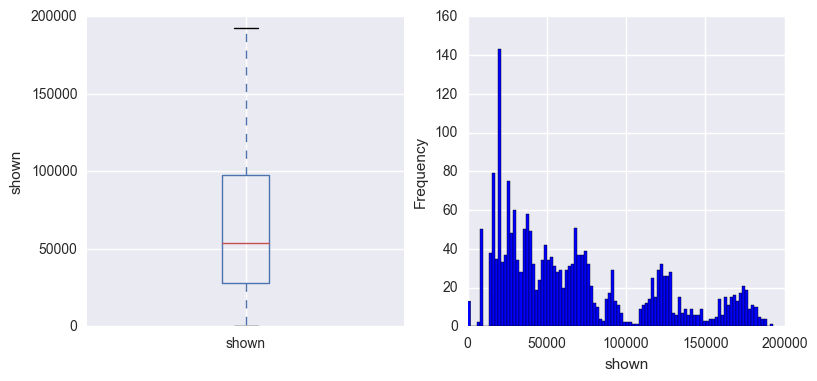

In [6]:
# Shown:
fig, axes = plt.subplots(1, 2, figsize=(9,4))
df.shown.plot.box(ax = axes[0])
df.shown.plot.hist(bins = 100, ax = axes[1], color = 'blue')
axes[0].set_ylabel("shown")
axes[1].set_xlabel("shown")

For all the groups combined, the are no outliers in the 'shown' column and the values seems sensible; that is 200000 is practically possible.

### Clicked:

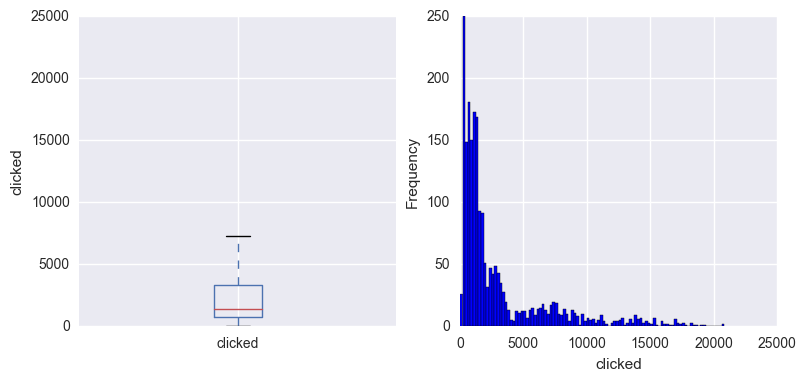

In [17]:
# Clicked:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
df.clicked.plot.box(ax = axes[0])
df.clicked.plot.hist(bins = 100, ax = axes[1], color = 'blue')
axes[0].set_ylabel("clicked")
axes[1].set_xlabel("clicked")

There are outliers in the 'clicked' column ( refer to whiskers in the boxplot(left) ). The maximum value is around 21000 which is much less than 'shown' column's maximum. Although it may seem good, we still need to check that 'clicked' <= 'shown'. It is impossible to have clicks more than the ads displayed.

In [13]:
df[ df['clicked'] > df['shown'] ]

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad


Great! The 'clicked' columns looks good. There are no data violating the condition 'clicked' <= 'shown'

### Converted:

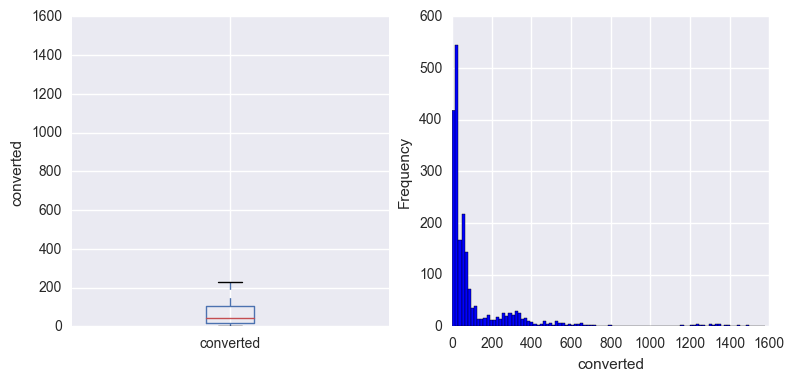

In [18]:
# converted:
fig, axes = plt.subplots(1, 2, figsize = (9, 4))
df.converted.plot.box(ax = axes[0])
df.converted.plot.hist(bins = 100, ax = axes[1], color = 'blue')
axes[0].set_ylabel("converted")
axes[1].set_xlabel("converted")

There are outliers in the 'converted' column as well. However, that could be related to a specific group(s). Therefore, it requires further investigation. 

The value should be less compared to the 'clicked' column. Lets check that.

In [16]:
df[df['converted'] > df['clicked']]

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad


Excellent! There are no data violating the condition 'converted' < 'clicked'.

### Average cost per click:

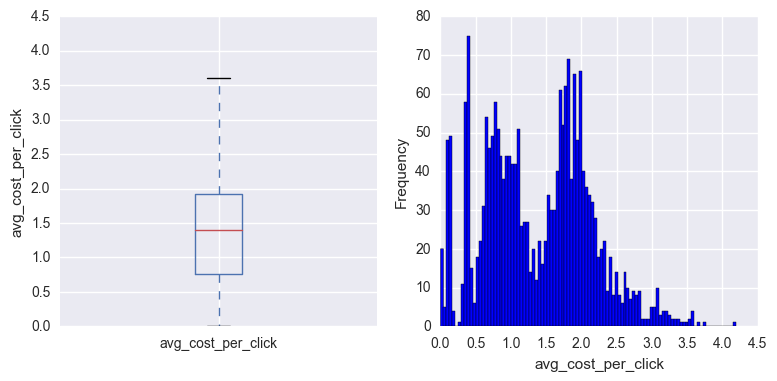

In [20]:
# avg_cost_per_click:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
df.avg_cost_per_click.plot.box(ax = axes[0])
df.avg_cost_per_click.plot.hist(bins = 100, ax = axes[1], color = 'blue')
axes[0].set_ylabel("avg_cost_per_click")
axes[1].set_xlabel("avg_cost_per_click")

Nice! The values makes sense. There may be few outliers. Although the maximum value is not outrageously high, the values over $3.5 may need further investigation which will be carried out in the follwing sections.

### Total Revenue:

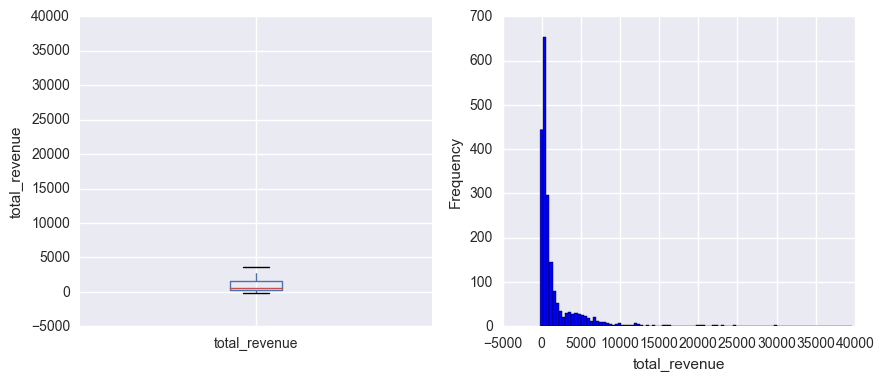

In [23]:
# total_revenue:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
df.total_revenue.plot.box(ax = axes[0])
df.total_revenue.plot.hist(bins = 100, ax = axes[1], color = 'blue')
axes[0].set_ylabel("total_revenue")
axes[1].set_xlabel("total_revenue")

Possibly, there are lot of outliers in the data. It could related to a specific ad groups as discussed before and requires indepth study. 

Does the 'total_revenue' has negative values? Let's check that.

In [8]:
df[df['total_revenue'] < 0]

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad
1186,2015-10-25,50459,1904,97,0.89,-200.15,ad_group_23
1404,2015-11-01,70145,584,15,0.36,-25.09,ad_group_27
1524,2015-11-15,22070,1400,20,1.67,-3.56,ad_group_29
2089,2015-10-28,80270,1151,41,0.96,-92.06,ad_group_40


Is it possible to have negative values for total_revenue? Yes. When the cost spent on advertisements (clicked) is more than the money gained from purchases (converted), then the revenue will be negative. Therefore, the negative values are allowed. 

## Data Sampling:

One more step in understanding the data is to know the amount of samples in each group. Are they equally distributed or one group has more samples than the other? This study will be helpful in data sampling step of modeling. It is important to sample the data that represents the population.

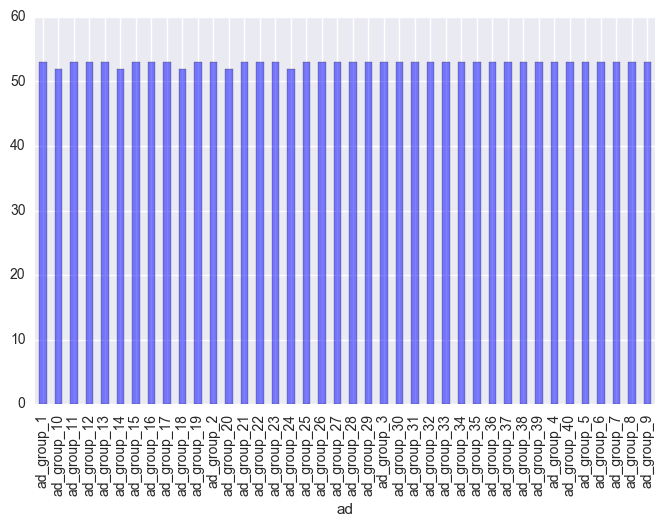

In [28]:
dff = df.groupby('ad')['shown'].count()
dff.plot.bar(color = 'b', alpha = 0.5, figsize = (8, 5))

The above bar chart clearly shows that we have almost equal number of data points for each ad group. So we could direct apply random sampling technique (Monte Carlo) to sample data for modeling. 

In case, the data is not uniformly distributed among the different ad groups, then we have to apply stratified sampling technique to pick sample data that represents the actual population. It is important to note that the stratified sampling is only applicable when we have similar dependancies between variables in each group such that the group category can be ignored in modeling.

## Data Engineering - Scatter plot (grid):

It is important to understand the relation between variables. In case of two numerical variables, we can simple use scatter plot. To study the relation between a numerical and a categorical variables, we can use bar chart. To find the relation between 2 categorical variables, stacked column chart can be used. As we have just 1 categorical variable in the dataset, we will not be using stacked column plot. 

### All numerical variables:

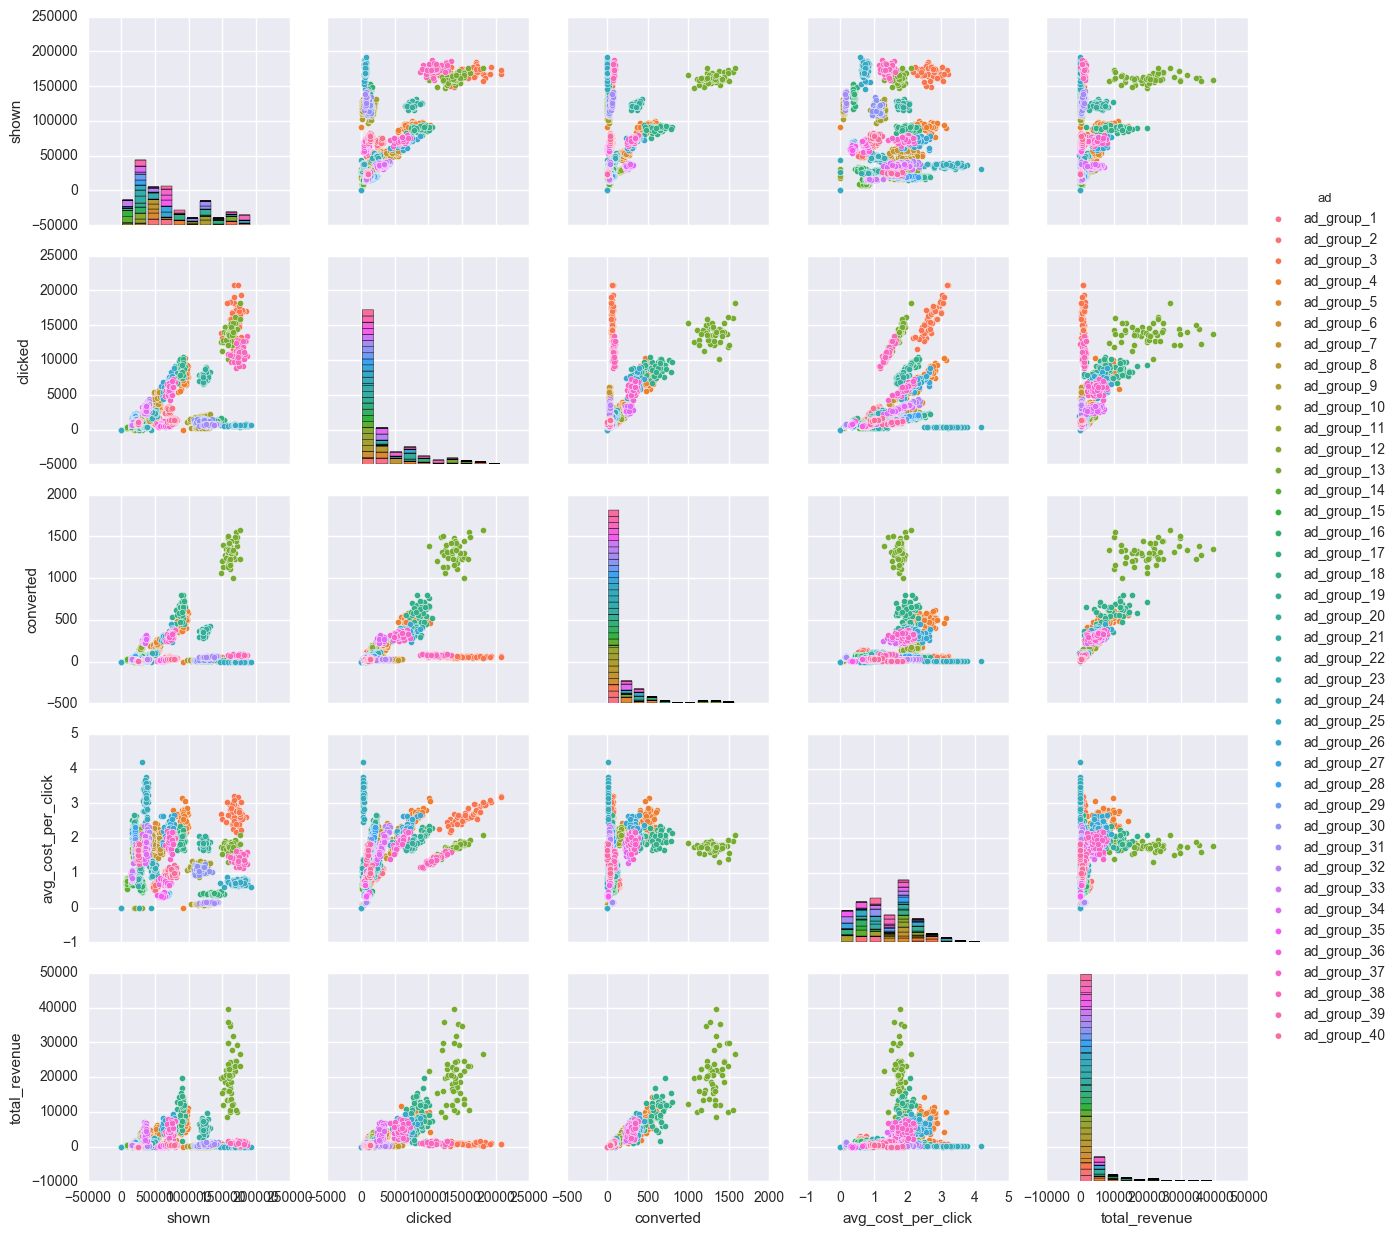

In [30]:
sns.pairplot(df[['shown', 'clicked', 'converted', 'avg_cost_per_click', 
                 'total_revenue', 'ad']], hue = 'ad')

Above pairplot shows no direct correlation between any of the variables in the table when data from all the groups combined are used. However, the plot shows clusters of data that might have linear and non-linear relationships between respective parameters. As we have multiple clusters in each of the above plots, when we segregate the data based on ad group we might discover some relationship between the parameters.

<b> Ad group 1: </b>

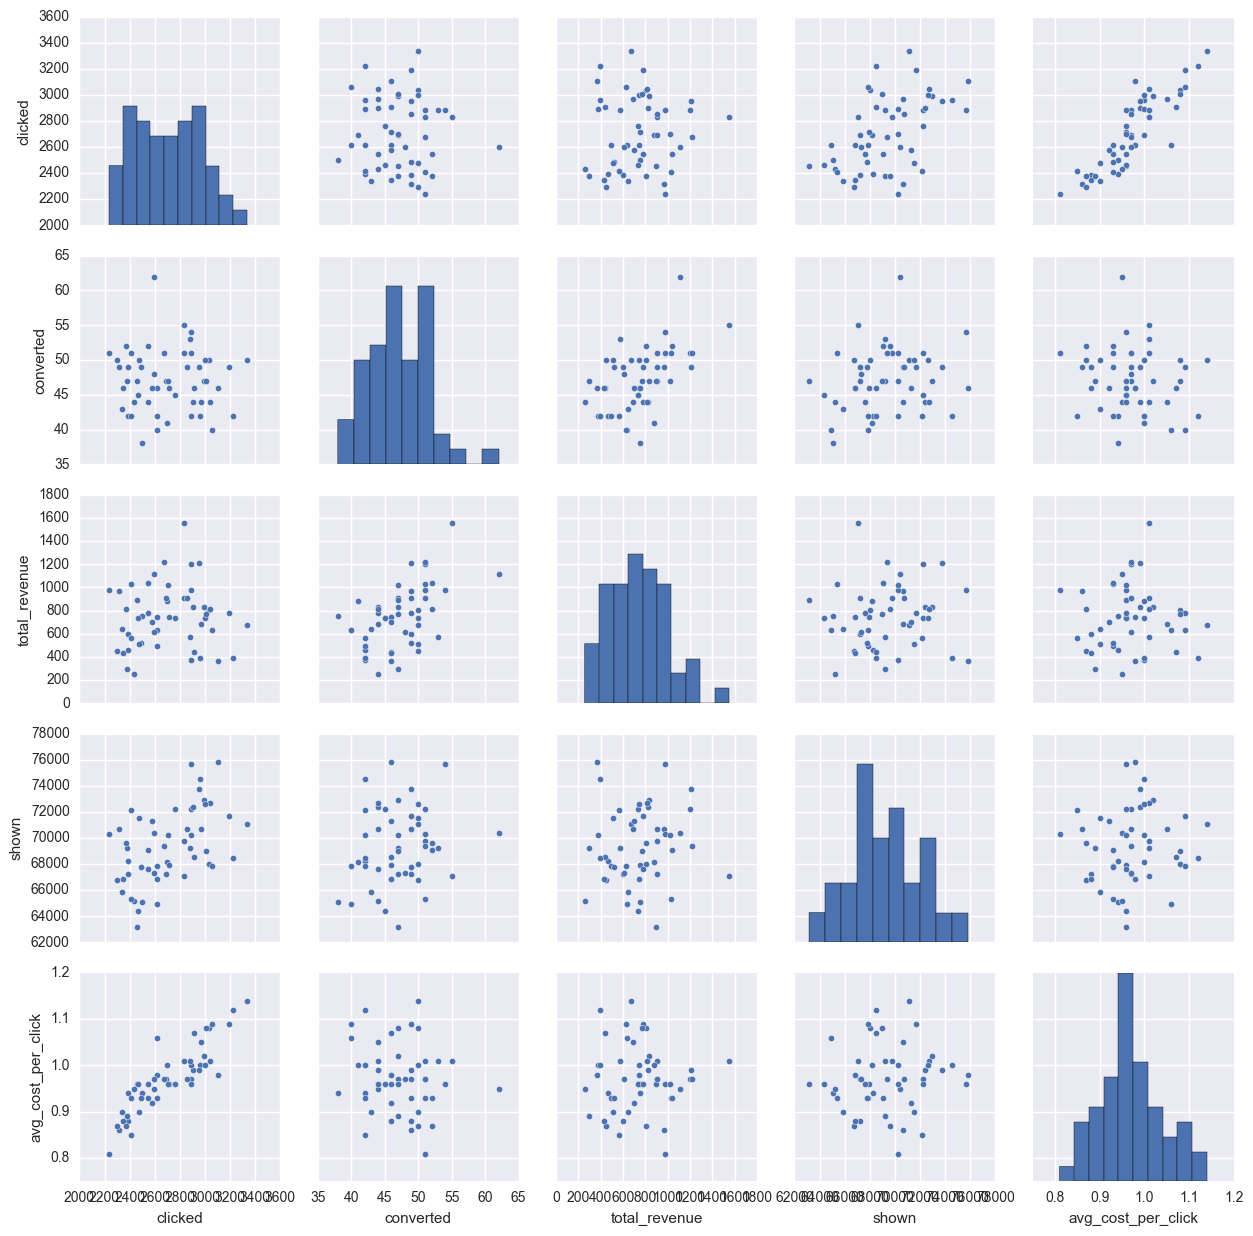

In [32]:
sns.pairplot(df.ix[df['ad'] == 'ad_group_1', {'shown', 'clicked', 'converted', 
                                              'avg_cost_per_click', 'total_revenue'}])

<b> Ad group 5: </b>

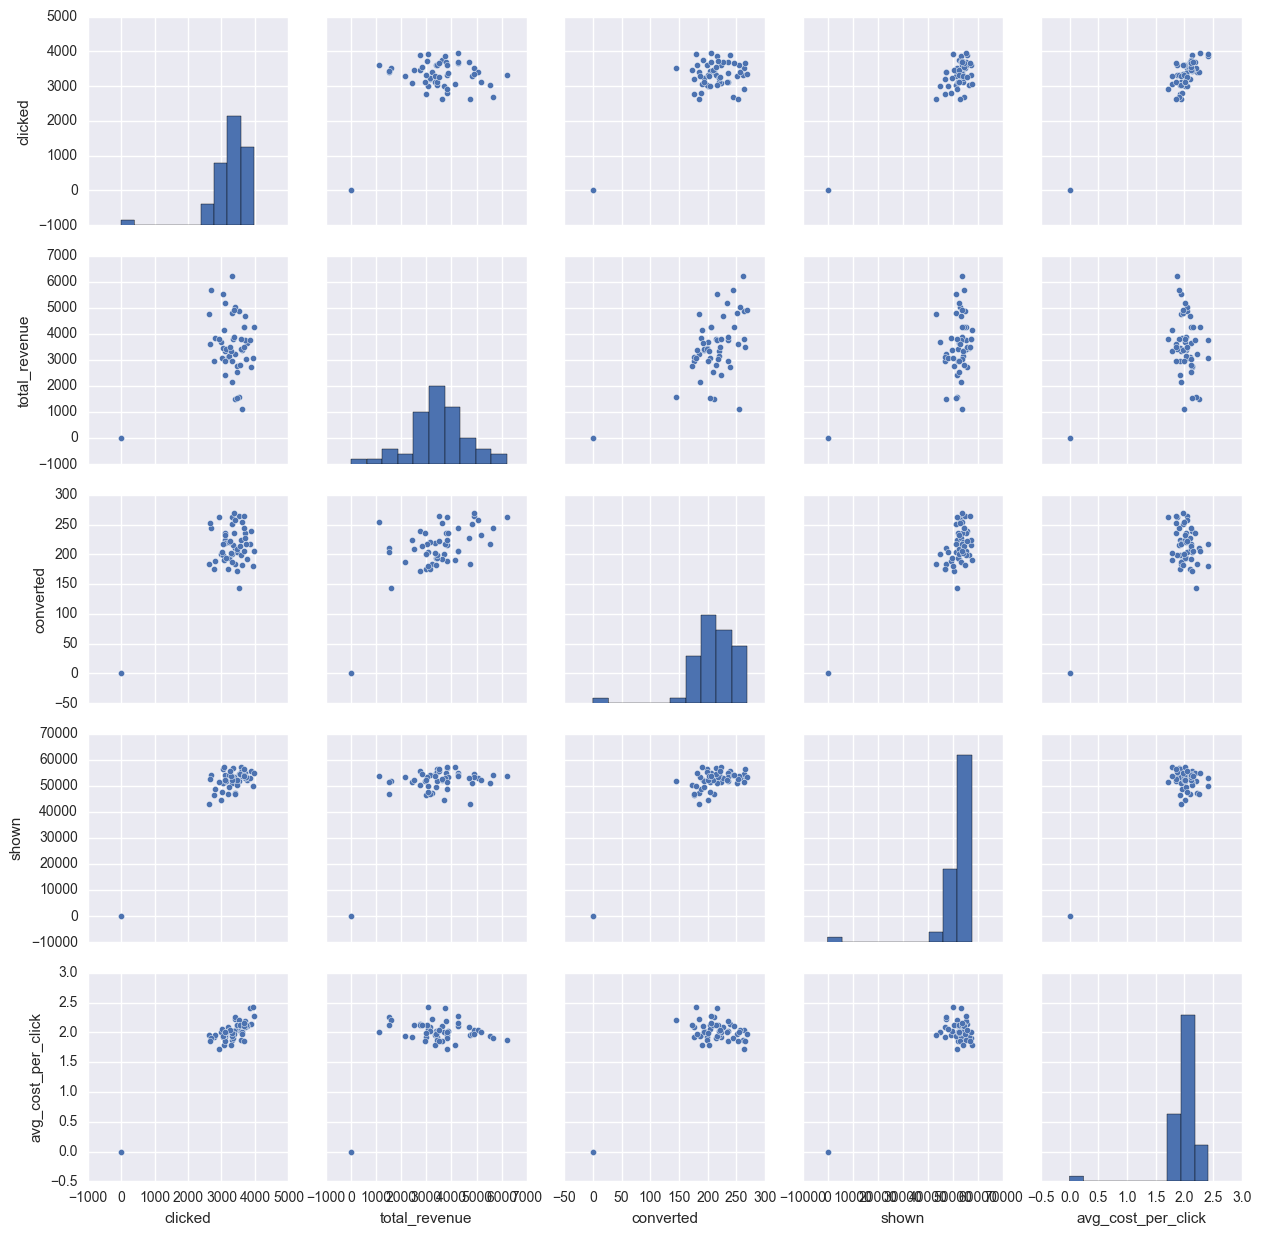

In [32]:
sns.pairplot(df.ix[df['ad'] == 'ad_group_5', {'shown', 'clicked', 'converted', 
                                              'avg_cost_per_click', 'total_revenue'}])

In the above plot for the ad_group 5 there are few outliers that could totally change the fitting curve or the model. So it is imperative to remove the outliers before proceding to the modeling step.

Again when we look at the plot with all the groups combined then we may not be able to identify these outliers as it could overlap with any other groups data. Therefore I am going to segregate the data based on groups and remove the outliers. 

Check again! Its always better check again than to mistakenly build an incorrect model. 

## Data cleanup - remove outliers:

Find the ratio of outliers, if insignificant just drop them or replace them with appropriate values

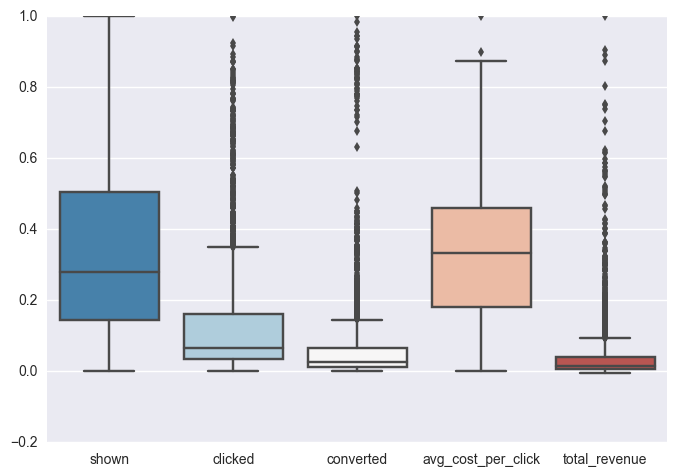

In [45]:
s = df[['shown', 'clicked', 'converted', 'avg_cost_per_click','total_revenue']]
ss = s / s.max()
sns.boxplot(ss, palette = 'RdBu_r')

When the data from all the groups are used to find the outliers, we get 100s of data points that are beyond 3 standard deviations (~99.5 percentile limit). When we remove them blindly then we might accidentally drop many useful observations from the data.

Let's check how the outliers look for a particular group, for instance group 5.

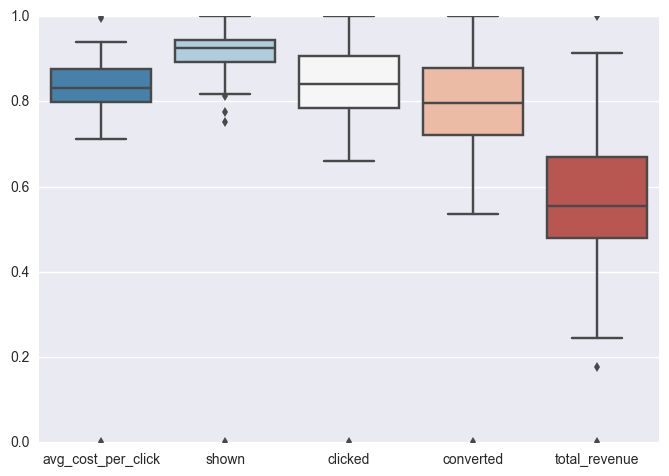

In [40]:
s = df.ix[df['ad'] == 'ad_group_5', {'shown', 'clicked', 'converted', 
                                     'avg_cost_per_click','total_revenue'}]
ss =  s / s.max()
sns.boxplot(ss, palette = 'RdBu_r')

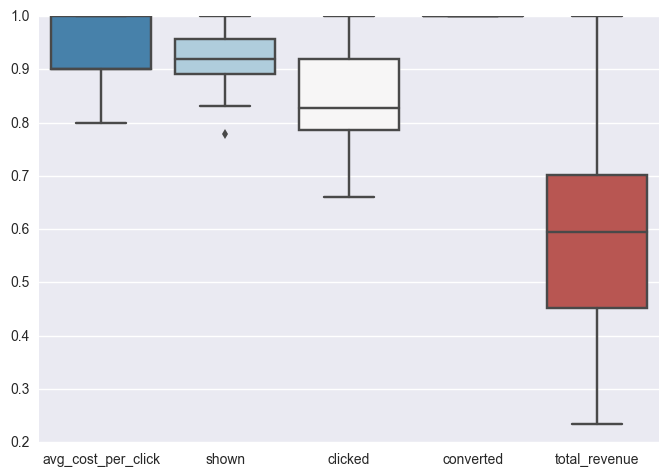

In [84]:
s = df.ix[df['ad'] == 'ad_group_9', {'shown', 'clicked', 'converted', 
                                     'avg_cost_per_click','total_revenue'}]
ss =  s / s.max()
sns.boxplot(ss, palette = 'RdBu_r')

In the above plot for the group 5, the outliers are just few and clearly distinct. Most importantly, it makes sense to remove outliers based on each group rather than all groups combined.

### Removing outliers from each column:

In [124]:
dff = df.copy(deep = True)

In [72]:
def remove_outliers(x):
    return x[(np.abs(stats.zscore(x)) < 3).all(axis = 1)]

In [125]:
columns = {'shown', 'clicked', 'converted', 'avg_cost_per_click','total_revenue'}
index_tobe_removed = []
# Implemented the follwing method as we have some columns with std == 0
for grp in dff.ad.unique():
    index_before = dff.ix[dff['ad'] == grp, columns].index.values # Index of each column
    dd_cols_std = dff.ix[(dff['ad'] == grp)].std() # columns to be considered
    dd_cols = list(dd_cols_std[dd_cols_std > 0].index.values) # removed cols with 0 std
    dd = remove_outliers( dff.ix[ (dff['ad'] == grp), dd_cols] )
    
    index_after = dd.index.values
    index_tobe_removed.extend(list(set(index_before) - set(index_after)))
    
print(index_tobe_removed)

# 1. Done this way because df(length = n) == df(length < n) - not possible to replace df of 
# unequal lengths.If it replacing with statistical mean or mode, it could be simply assigned (replaced).
# So select only the indices of the data to be removed.
# 2. std is checked for each column separately and columns with same values is dropped 
# otherwise all the values are assumed to be outside 3 std limit as the std = 0. 
# Then we will endup deleting the entire group

[17, 28, 201, 204, 223, 525, 554, 570, 566, 580, 632, 607, 650, 676, 811, 821, 893, 899, 1000, 1005, 1057, 1091, 1211, 1175, 1215, 1273, 1471, 1556, 1697, 1737, 1744, 1843, 1852, 1928, 2089, 2062]


Dimension before removing outliers:

In [126]:
dff.shape

(2115, 7)

Dimension after removing outliers:

In [127]:
dff.drop(dff.index[index_tobe_removed], inplace = True)
dff.shape

(2079, 7)

<b> Outliers removed!! </b>

Lets verify using scatter or boxplot

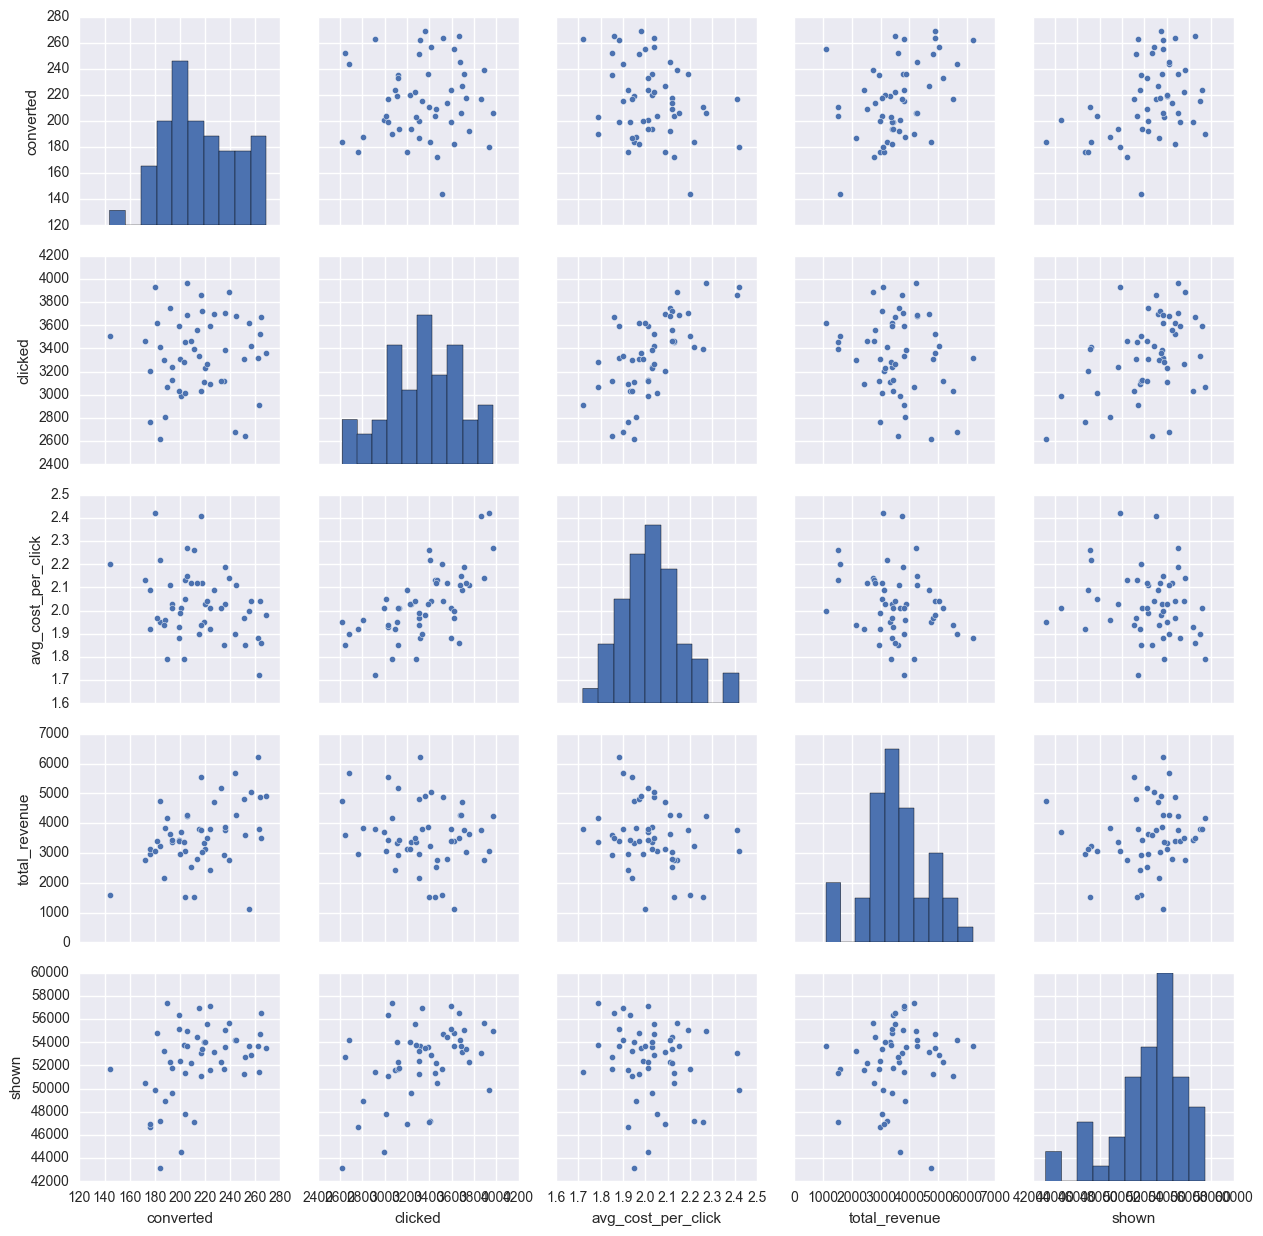

In [10]:
sns.pairplot(dff.ix[dff['ad'] == 'ad_group_5', {'shown', 'clicked', 'converted', 
                                                'avg_cost_per_click', 'total_revenue'}])

When we compare the above plot for the group 5 with outliers removed and the same plot with outliers not removed, we could easy notice the difference. Now we can clearly see the spread of the data between any 2 parameters and we might be able come up with a reasonably good model.

In [7]:
dff.to_csv("./data/ad_table_cleaned_outliers.csv", index = False)

# Feature Engineering:

In [3]:
dff = pd.read_csv("./data/ad_table_cleaned_outliers.csv")
dff['date'] = pd.to_datetime(dff['date'])
dff.head()

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1


Let's add new variables that might be helpful for developing an accurate model

### Adding ratios:

In [4]:
dff['CTR'] = dff['clicked'] / dff['shown']
dff['CR'] = dff['converted'] / dff['clicked']

### Adding info from timestamps:

In [5]:
US_holidays = holidays.US()
dff['business_day'] = [isbday(x, US_holidays) for x in dff['date']]
dff['Week_day'] = [ x.weekday() for x in dff['date']]
# Same as Week_day column but with day names instead of nominal values. Only for exploration.
dff['Week_day_name'] = [calendar.day_name[x] for x in dff['Week_day']]
dff.head()

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad,CTR,CR,business_day,Week_day,Week_day_name
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1,0.035506,0.018384,True,3,Thursday
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1,0.038372,0.015212,True,4,Friday
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1,0.032735,0.021185,False,5,Saturday
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1,0.040582,0.018002,False,6,Sunday
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1,0.039539,0.015208,True,0,Monday


Now we have added new variables,<br>
<b>CTR</b> - Click-through rate<br>
<b>CR</b> - Conversion rate<br>
<b>business_day</b> - working day (1) or holiday (0)<br>
<b>Week_day</b> - Day of the week (0-6 -> Monday to Sunday)<br>
<b>Week_day_name</b> - Name of the weekday

In the following section, let's analyse the importance of these variables and decide whether to retain them in the dataset or drop them

In [6]:
dff.to_csv("./data/ad_table_data_engineering.csv", index = 0)

# Data exploration

In [7]:
dff = pd.read_csv("./data/ad_table_data_engineering.csv")
dff['date'] = pd.to_datetime(dff['date'])
dff.head()

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad,CTR,CR,business_day,Week_day,Week_day_name
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1,0.035506,0.018384,True,3,Thursday
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1,0.038372,0.015212,True,4,Friday
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1,0.032735,0.021185,False,5,Saturday
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1,0.040582,0.018002,False,6,Sunday
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1,0.039539,0.015208,True,0,Monday


Does weekday and holiday category correlates to the target variable??

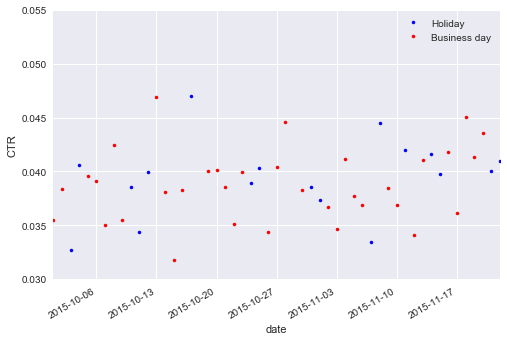

In [8]:
plt.figure()
ax = dff.ix[(dff.ad == 'ad_group_1') & (dff['business_day'] == 0)].plot('date', 'CTR', 
                                                                         style = 'b.', label = "Holiday")
dff.ix[(dff.ad == 'ad_group_1') & (dff['business_day'] == 1)].plot('date', 'CTR', 
                                                                    style = 'r.', ax = ax, 
                                                                    label = "Business day")
ax.set_ylabel("CTR")
ax.set_ylim(0.03, 0.055)
plt.legend()
plt.show()

In [9]:
dff_Week_day_name = pd.DataFrame()
dff_Week_day_name['avg'] = dff.groupby(['ad', 'Week_day_name'])['CTR'].mean()
dff_Week_day_name['std'] = dff.groupby(['ad', 'Week_day_name'])['CTR'].std()
dff_Week_day_name = dff_Week_day_name.reset_index()
dff_Week_day_name.head()

,ad,Week_day_name,avg,std
0,ad_group_1,Friday,0.038979,0.002514
1,ad_group_1,Monday,0.038705,0.002479
2,ad_group_1,Saturday,0.038861,0.004519
3,ad_group_1,Sunday,0.039686,0.003150
4,ad_group_1,Thursday,0.036860,0.003864


In [10]:
dff_Week_day_name['COV'] = dff_Week_day_name['std'] / dff_Week_day_name['avg']

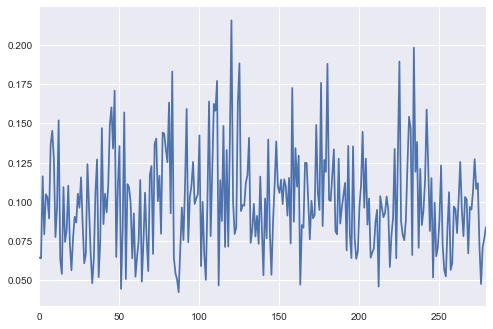

In [11]:
dff_Week_day_name['COV'].plot()

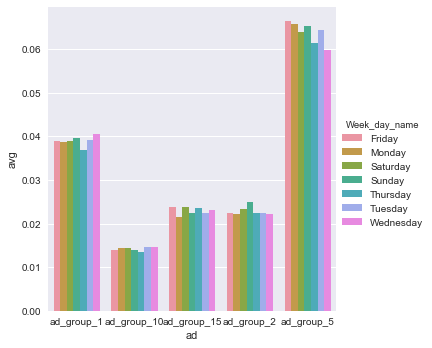

In [14]:
dd = dff_Week_day_name[dff_Week_day_name['ad'].isin(['ad_group_1', 'ad_group_2', 'ad_group_15', 
                                                     'ad_group_5', 'ad_group_10'])]
sns.factorplot(x = 'ad', y = 'avg', hue = 'Week_day_name', data = dd, kind="bar", size = 5)

In [16]:
dff_business_day = dff.groupby(['ad', 'business_day'])['CTR'].mean()
dff_business_day = dff_business_day.reset_index()
dff_business_day.head()

,ad,business_day,CTR
0,ad_group_1,False,0.039450
1,ad_group_1,True,0.038749
2,ad_group_10,False,0.014186
3,ad_group_10,True,0.014115
4,ad_group_11,False,0.064801


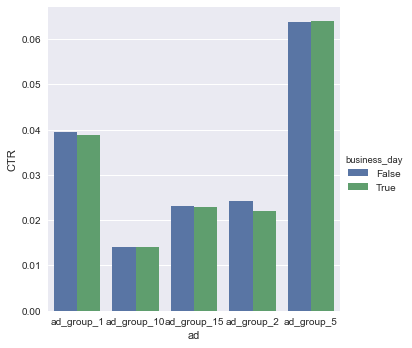

In [17]:
dd = dff_business_day[dff_business_day['ad'].isin(['ad_group_1', 'ad_group_2', 'ad_group_15', 'ad_group_5', 'ad_group_10'])]
sns.factorplot(x = 'ad', y = 'CTR', hue = 'business_day', data = dd, kind="bar", size = 5)

## Quality Factor

Finally lets compute the Quality Factor:

$$QF = \frac{{CTR + CR + CP{C^{ - 1}} + W{S^{ - 1}} + RCPC}}{5}$$

$CTR = \frac{{{\rm{ads\_clicked}}}}{{{\rm{ads\_shown}}}}$ <br>
$CR = \frac{{{\rm{ads\_converted}}}}{{{\rm{ads\_clicked}}}}$ <br>
$CPC = \frac{{{\rm{total\_amount\_spent}}}}{{{\rm{ads\_converted}}}}$ <br>
$WS = {(clicked - converted)} * {avg\_cost\_per\_click} $ <br>
$RCPC = \frac{{{\rm{Total\_revenue}}}}{{{\rm{ads\_clicked}}}}$ <br>

In [22]:
dff.drop(['business_day', 'Week_day', 'Week_day_name'], axis = 1, inplace = True)

In [23]:
dff.head()

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad,CTR,CR
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1,0.035506,0.018384
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1,0.038372,0.015212
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1,0.032735,0.021185
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1,0.040582,0.018002
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1,0.039539,0.015208


In [24]:
money_spent = dff['avg_cost_per_click']*dff['clicked']

dff['CPC'] = money_spent / dff['converted']
dff['WS'] = (dff['clicked'] - dff['converted']) * dff['avg_cost_per_click']
dff['RCPC'] = dff['total_revenue'] / dff['clicked']

In [25]:
dff.head()

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad,CTR,CR,CPC,WS,RCPC
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1,0.035506,0.018384,48.955814,2066.40,0.274314
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1,0.038372,0.015212,61.792632,2312.40,0.302790
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1,0.032735,0.021185,40.595510,1947.04,0.419758
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1,0.040582,0.018002,56.104510,2809.82,0.320293
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1,0.039539,0.015208,65.756098,2655.00,0.326205


$$QF = \frac{{CTR + CR + CP{C^{ - 1}} + W{S^{ - 1}} + RCPC}}{5}$$

In [33]:
print("CTR - min: %.3f, max: %.3f" %(dff.CTR.min(), dff.CTR.max()))
print("CR - min: %.3f, max: %.3f" %(dff.CR.min(), dff.CR.max()))
print("CPC - min: %.3f, max: %.3f" %(dff.CPC.min(), dff.CPC.max()))
print("WS - min: %.3f, max: %.3f" %(dff.WS.min(), dff.WS.max()))
print("RCPC - min: %.3f, max: %.3f" %(dff.RCPC.min(), dff.RCPC.max()))

CTR - min: 0.002, max: 0.124
CR - min: 0.000, max: 0.145
CPC - min: 1.034, max: inf
WS - min: 17.360, max: 66710.220
RCPC - min: -0.105, max: 2.900


In [39]:
np.percentile(dff.CPC, 0.999)

1.6047081707707072

In [40]:
np.percentile(dff.WS, 0.999)

21.668329799999995

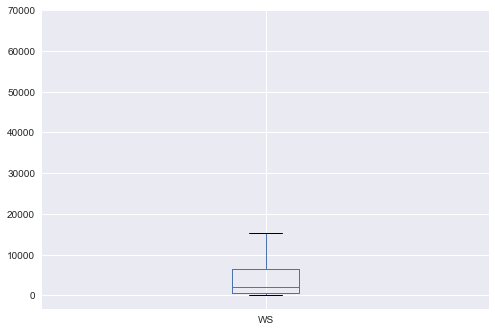

In [44]:
dff['WS'].plot.box()

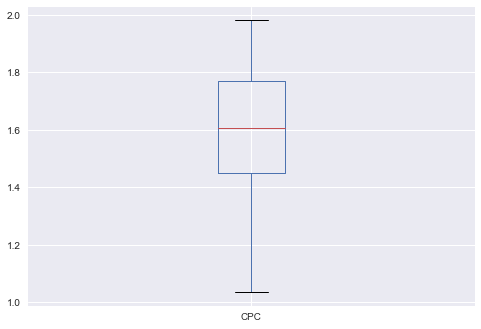

In [45]:
dff.ix[dff['CPC'] < 2, 'CPC'].plot.box()

### Compute Quality factor:

In [26]:
dff['QF'] = (dff['CTR'] + dff['CR'] + dff['RCPC'] + (1/dff['CPC']) + (1/dff['WS'])) / 5

In [27]:
dff[['CTR', 'CR', 'CPC', 'WS', 'RCPC', 'QF']].head(10)

,CTR,CR,CPC,WS,RCPC,QF
0,0.035506,0.018384,48.955814,2066.40,0.274314,0.069823
1,0.038372,0.015212,61.792632,2312.40,0.302790,0.074598
2,0.032735,0.021185,40.595510,1947.04,0.419758,0.099765
3,0.040582,0.018002,56.104510,2809.82,0.320293,0.079411
4,0.039539,0.015208,65.756098,2655.00,0.326205,0.079307
5,0.039139,0.017577,55.753478,2519.58,0.285243,0.072058
6,0.035030,0.017573,53.490476,2207.12,0.193444,0.053039
7,0.042455,0.015813,67.665870,3063.41,0.151695,0.045013
8,0.035465,0.020545,42.832653,2055.68,0.252470,0.066462
9,0.038513,0.016067,57.881429,2391.96,0.187663,0.051988


As the scaling is different on the 5 parameters, their weights will be different (not talking about ${w_1}$, ${w_2}$, ${w_3}$, ${w_4}$, and ${w_5}$). Explain more... 

To solve the unequal parametric range on the 5 parameters, we can apply mean normalization technique

In [35]:
from sklearn.preprocessing import MinMaxScaler as MM

In [36]:
minmax_scaler = MM()

Before applying the MinMax scaler to all the 5 parameters, we should reverse CPC and WS.

In [13]:
dff['CPC_1'] = 1/dff['CPC']
dff['WS_1'] = 1/dff['WS']

# Lets print the max and min checking for inf (or -inf) in the data:
print("Max and Min of CPC_1: %.2f and %.2f" %(dff['CPC_1'].max(), dff['CPC_1'].min()))
print("Max and Min of WS_1: %.2f and %.2f" %(dff['WS_1'].max(), dff['WS_1'].min()))

Max and Min of CPC_1: 0.97 and 0.00
Max and Min of WS_1: 869.47 and -5395875303543275.00


As suspected, the range of WS_1 is quite wide and needs further investigation to remove outliers.

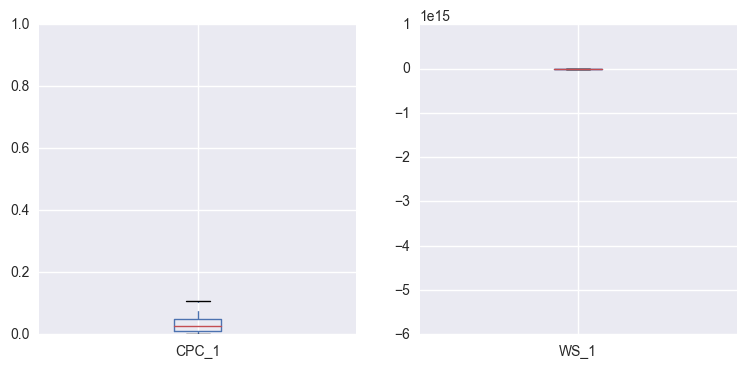

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(9,4))
dff[['CPC_1']].plot.box(ax = axes[0])
dff[['WS_1']].plot.box(ax = axes[1])
plt.show()

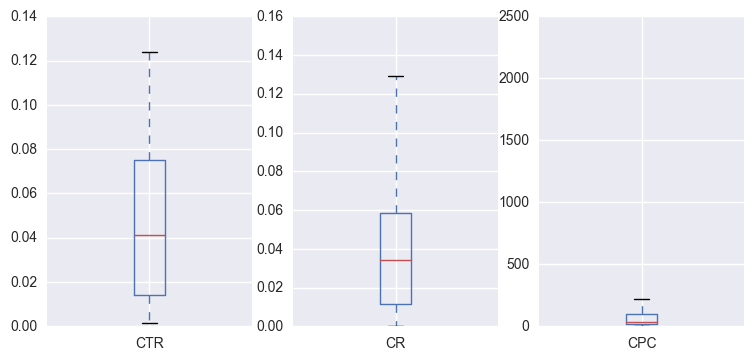

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(9,4))
dff[['CTR']].plot.box(ax = axes[0])
dff[['CR']].plot.box(ax = axes[1])
dff[['CPC']].plot.box(ax = axes[2])
plt.show()

As we have outliers in all the 5 parameters, let remove them. Also few outlier may be of a particular group, so we need be careful in not eliminating large portion of data from a group. We will check for count again after outliers removal.

In [16]:
def remove_outliers(x):
    return x[(np.abs(stats.zscore(x)) < 1.96).all(axis = 1)]
# 2.576 corresponds to 99 confidence interval
# 1.96 corresponds to 95 confidence interval

In [17]:
dff.drop(['CPC', 'WS'], axis = 1, inplace = True)

In [18]:
dff.head()

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad,CTR,CR,business_day,Week_day,RCPC,QF,CPC_1,WS_1
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1,0.035506,0.018384,True,3,0.274314,0.357410,0.020427,1.438421
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1,0.038372,0.015212,True,4,0.302790,0.369548,0.016183,1.475181
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1,0.032735,0.021185,False,5,0.419758,0.490356,0.024633,1.953471
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1,0.040582,0.018002,False,6,0.320293,0.372218,0.017824,1.464390
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1,0.039539,0.015208,True,0,0.326205,0.376058,0.015208,1.484132


In [19]:
dff.shape

(2079, 15)

In [20]:
dd = dff[['CTR', 'CR', 'CPC_1', 'WS_1', 'RCPC', 'QF']].copy(deep = True)
dd = remove_outliers( dd )

In [21]:
dd.shape

(1874, 6)

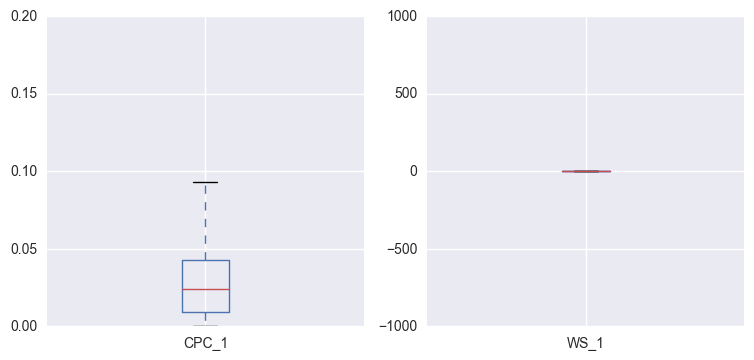

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(9,4))
dd[['CPC_1']].plot.box(ax = axes[0])
dd[['WS_1']].plot.box(ax = axes[1])
plt.show()

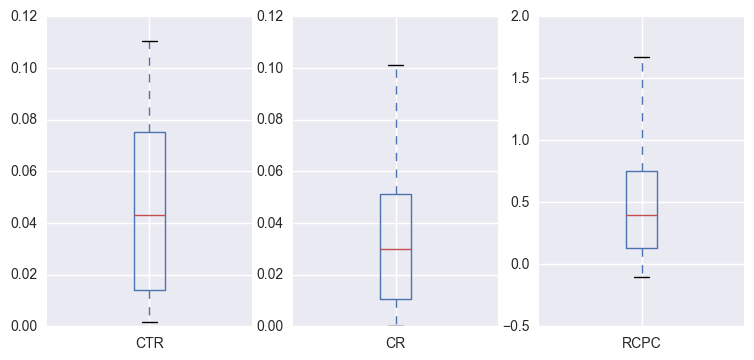

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(9,4))
dd[['CTR']].plot.box(ax = axes[0])
dd[['CR']].plot.box(ax = axes[1])
dd[['RCPC']].plot.box(ax = axes[2])
plt.show()

(-20, 20)

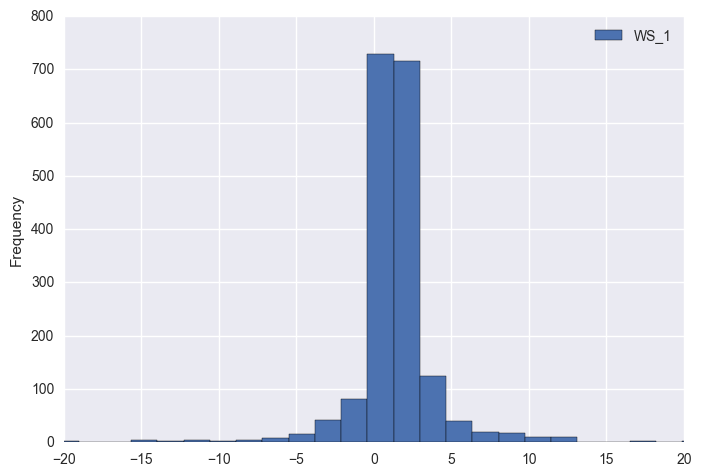

In [24]:
ax = dd[['WS_1']].plot.hist(bins = 1000)
ax.set_xlim(-20, 20)

In [25]:
dd[abs(dd['WS_1']) < 15].shape

(1826, 6)

Manually limited to be within sensible limit:

In [26]:
dd = dd[abs(dd['WS_1']) < 15]

In [29]:
dff = dff.iloc[dd.index].reset_index( drop = True )

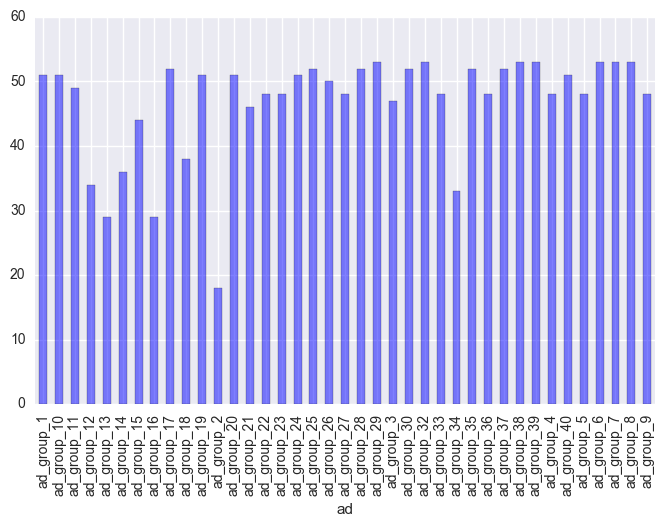

In [30]:
ff = dff.groupby('ad')['shown'].count()
ff.plot.bar(color = 'b', alpha = 0.5, figsize = (8, 5))

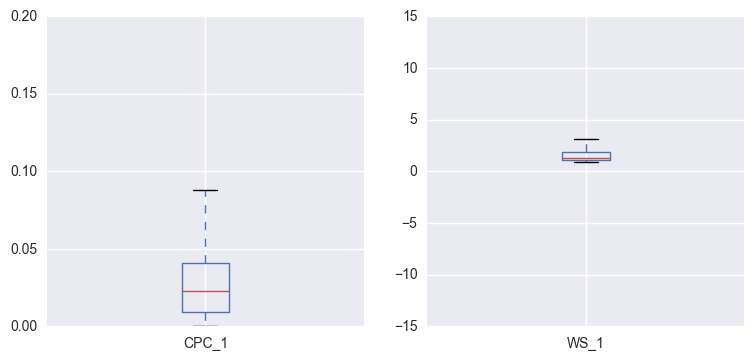

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(9,4))
dff[['CPC_1']].plot.box(ax = axes[0])
dff[['WS_1']].plot.box(ax = axes[1])
plt.show()

In [32]:
dff.head()

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad,CTR,CR,business_day,Week_day,RCPC,QF,CPC_1,WS_1
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1,0.035506,0.018384,True,3,0.274314,0.357410,0.020427,1.438421
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1,0.038372,0.015212,True,4,0.302790,0.369548,0.016183,1.475181
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1,0.032735,0.021185,False,5,0.419758,0.490356,0.024633,1.953471
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1,0.040582,0.018002,False,6,0.320293,0.372218,0.017824,1.464390
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1,0.039539,0.015208,True,0,0.326205,0.376058,0.015208,1.484132


In [33]:
import warnings as warn
warn.simplefilter('ignore')

In [37]:
dff[['CTR', 'CR', 'CPC_1', 'WS_1', 'RCPC']] = minmax_scaler.fit_transform( dff[['CTR', 'CR', 'CPC_1', 'WS_1', 'RCPC']] )

In [38]:
dff[['CTR', 'CR', 'CPC_1', 'WS_1', 'RCPC']].head()

,CTR,CR,CPC_1,WS_1,RCPC
0,0.311170,0.182065,0.109313,0.583097,0.213484
1,0.337506,0.150654,0.086605,0.584413,0.229506
2,0.285715,0.209802,0.131826,0.601530,0.295316
3,0.357817,0.178284,0.095385,0.584026,0.239354
4,0.348231,0.150610,0.081385,0.584733,0.242680


In [39]:
dff['QF'] = (dff['CTR'] + dff['CR'] + dff['RCPC'] + dff['CPC_1'] + dff['WS_1']) / 5

In [40]:
dff.head()

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad,CTR,CR,business_day,Week_day,RCPC,QF,CPC_1,WS_1
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1,0.311170,0.182065,True,3,0.213484,0.279826,0.109313,0.583097
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1,0.337506,0.150654,True,4,0.229506,0.277737,0.086605,0.584413
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1,0.285715,0.209802,False,5,0.295316,0.304838,0.131826,0.601530
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1,0.357817,0.178284,False,6,0.239354,0.290973,0.095385,0.584026
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1,0.348231,0.150610,True,0,0.242680,0.281528,0.081385,0.584733


In [41]:
ranks = dff.groupby('ad')['QF'].mean()

In [42]:
ranks = ranks.reset_index().set_index('ad', drop = True)

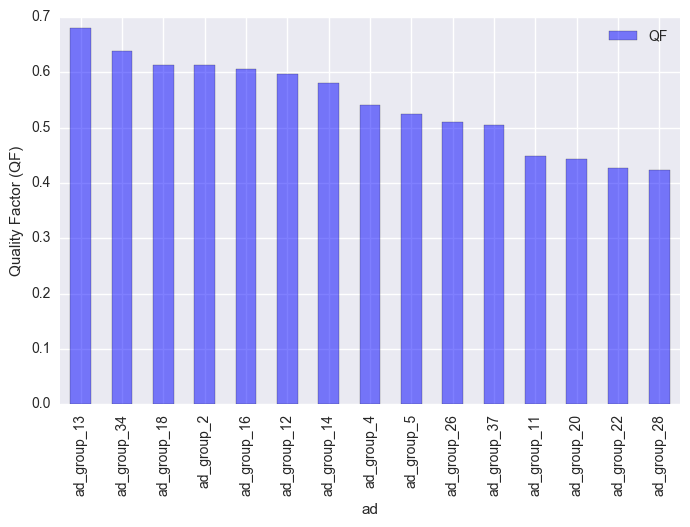

In [49]:
ax = ranks.sort('QF', ascending = False)[:15].plot.bar(color = 'b', alpha = 0.5, figsize = (8, 5))
ax.set_ylabel("Quality Factor (QF)")

In [54]:
ranks.sort('QF', ascending = False)[:5].index.values.tolist() # Ranked in order

['ad_group_13', 'ad_group_34', 'ad_group_18', 'ad_group_2', 'ad_group_16']

From the above bar chart, it is evident that the top 5 best performing Ad campaigns are 
1. ad_group_13
2. ad_group_34
3. ad_group_18
4. ad_group_2
5. ad_group_16

In [57]:
dff.to_csv("./data/ad_table_cleaned_QF.csv", index = False)

----------------------------------------------------------------------------------------------------

# 2. Prediction

Question: For each group predict, how many ads will be shown on a particular date (let's say Dec 15) by assuming that each group follows its trend.

In [2]:
dff = pd.read_csv("./data/ad_table_cleaned_QF.csv")
dff['date'] = pd.to_datetime(dff['date'])
dff.head()

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad,CTR,CR,business_day,Week_day,RCPC,QF,CPC_1,WS_1
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1,0.311170,0.182065,True,3,0.213484,0.279826,0.109313,0.583097
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1,0.337506,0.150654,True,4,0.229506,0.277737,0.086605,0.584413
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1,0.285715,0.209802,False,5,0.295316,0.304838,0.131826,0.601530
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1,0.357817,0.178284,False,6,0.239354,0.290973,0.095385,0.584026
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1,0.348231,0.150610,True,0,0.242680,0.281528,0.081385,0.584733


For predictive analysis, we do not need QF and other parameters that involve simple mathematical operations such as multiplication, division, etc. This would lead to a well-known problem called multicollinearity. To avoid that we can simple remove the respective columns.

In [3]:
df_prediction = dff.copy( deep = True )

Before removing the columns blindly, lets check for multicollinearity using correlation matrix:

In [4]:
df_prediction.columns

Index(['date', 'shown', 'clicked', 'converted', 'avg_cost_per_click',
       'total_revenue', 'ad', 'CTR', 'CR', 'business_day', 'Week_day', 'RCPC',
       'QF', 'CPC_1', 'WS_1'],
      dtype='object')

## Parameter selection:

In [6]:
cols = list( set(df_prediction.columns) - set(['business_day', 'Week_day']) )
corr_matrix = df_prediction[cols].corr()
print(corr_matrix)

                         CTR        QF     shown  converted     CPC_1  \
CTR                 1.000000  0.533050 -0.098512   0.486115 -0.253923   
QF                  0.533050  1.000000 -0.272891   0.625391  0.554263   
shown              -0.098512 -0.272891  1.000000   0.269234 -0.251693   
converted           0.486115  0.625391  0.269234   1.000000  0.092083   
CPC_1              -0.253923  0.554263 -0.251693   0.092083  1.000000   
total_revenue       0.476750  0.632770  0.259277   0.953915  0.076197   
RCPC                0.242854  0.896027 -0.243941   0.526277  0.585014   
avg_cost_per_click  0.707638  0.265157 -0.103490   0.335797 -0.445806   
clicked             0.638192  0.292213  0.568931   0.626578 -0.227807   
CR                  0.244423  0.925590 -0.283538   0.564879  0.693638   
WS_1                0.097086  0.192513  0.072675   0.218983 -0.126299   

                    total_revenue      RCPC  avg_cost_per_click   clicked  \
CTR                      0.476750  0.242854   

<b> Correlation Matrix (Heat Map) - Based on Pearson's correlation coefficients:

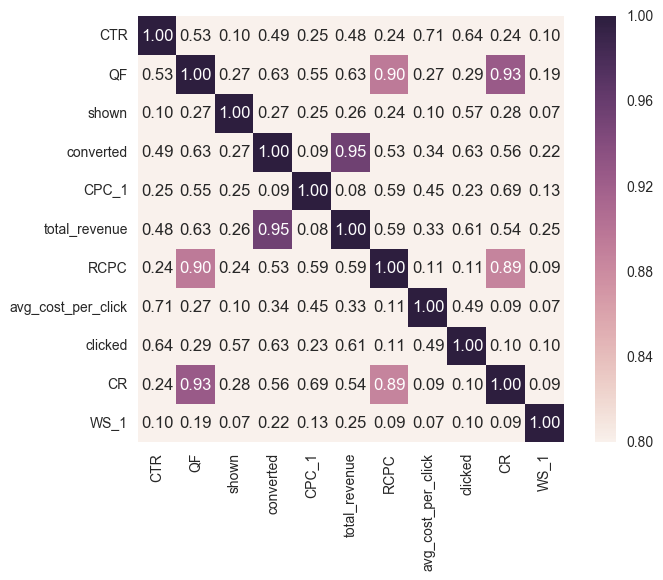

In [7]:
sns.heatmap(abs(corr_matrix), vmax = 1, vmin = 0.8, square = True, annot=True, fmt=".2f" )

$$QF = \frac{{CTR + CR + CP{C^{ - 1}} + W{S^{ - 1}} + RCPC}}{5}$$

$CTR = \frac{{{\rm{ads\_clicked}}}}{{{\rm{ads\_shown}}}}$
$CR = \frac{{{\rm{ads\_converted}}}}{{{\rm{ads\_clicked}}}}$
$CPC = \frac{{{\rm{total\_amount\_spent}}}}{{{\rm{ads\_converted}}}}$
$WS = \frac{{{\rm{Total\_money\_spent - Money\_gained\_on\_conversions}}}}{{{\rm{Total\_money\_spent}}}}$
$RCPC = \frac{{{\rm{Total\_revenue}}}}{{{\rm{ads\_clicked}}}}$

Here, for the predictive analysis, the target variable is <b> "shown" </b> <br>
It is much easier to visualize and get information from the above heatmap than from the previous table.
1. abs(corr_matrix) - We care about the magnitude of the correlation coefficient. It doesnt matter if it positively correlated or negatively correlated.
2. The dark colors shows the variables that are highly correlated with other parameters in the dataset. Lets list them all and remove if necesssary to solve multicollinearity issue. <br>
    i. total_revenue and converted - perfectly correlated. It makes perfect sense that the total revenue generated is directly proportional to the converted ads. Also, the both have the same correlation coefficient with our target variable "shown". So it is important to remove one of these 2 parameters before modeling. 
    As an implication, the RCPC and CR will be highly correlated as they are proportional to the total_revenue and converted, respectively.<br>
    ii. RCPC, QF, CR - highly correlated with each other. As expected, refer to the previous point, RCPC and CR are highly correlated. Although, correlation with QF is normal or erxpected, high correlation coefficient of 0.9 is unexpected. This tells us that RCPC and CR mainly determines the value of QF. 

<b> To be removed: </b> CR, RCPC, total_revenue, and QF

In [8]:
cols_remove = ['CR', 'RCPC', 'total_revenue', 'QF']
df_prediction.drop(cols_remove, axis = 1, inplace = 1)

In [9]:
df_prediction.head()

,date,shown,clicked,converted,avg_cost_per_click,ad,CTR,business_day,Week_day,CPC_1,WS_1
0,2015-10-01,65877,2339,43,0.90,ad_group_1,0.311170,True,3,0.109313,0.583097
1,2015-10-02,65100,2498,38,0.94,ad_group_1,0.337506,True,4,0.086605,0.584413
2,2015-10-03,70658,2313,49,0.86,ad_group_1,0.285715,False,5,0.131826,0.601530
3,2015-10-04,69809,2833,51,1.01,ad_group_1,0.357817,False,6,0.095385,0.584026
4,2015-10-05,68186,2696,41,1.00,ad_group_1,0.348231,True,0,0.081385,0.584733


We should also remove any variable that is a function of the target variable. As CTR is the ratio of clicked and shown, it should be removed as well.

In [96]:
df_prediction.drop('CTR', axis = 1, inplace = 1)

In [97]:
df_prediction.head()

,date,shown,clicked,converted,avg_cost_per_click,ad,business_day,Week_day,CPC_1,WS_1
0,2015-10-01,65877,2339,43,0.90,ad_group_1,True,3,0.109313,0.583097
1,2015-10-02,65100,2498,38,0.94,ad_group_1,True,4,0.086605,0.584413
2,2015-10-03,70658,2313,49,0.86,ad_group_1,False,5,0.131826,0.601530
3,2015-10-04,69809,2833,51,1.01,ad_group_1,False,6,0.095385,0.584026
4,2015-10-05,68186,2696,41,1.00,ad_group_1,True,0,0.081385,0.584733


Lets check for seasonality in the data from the timestamp:

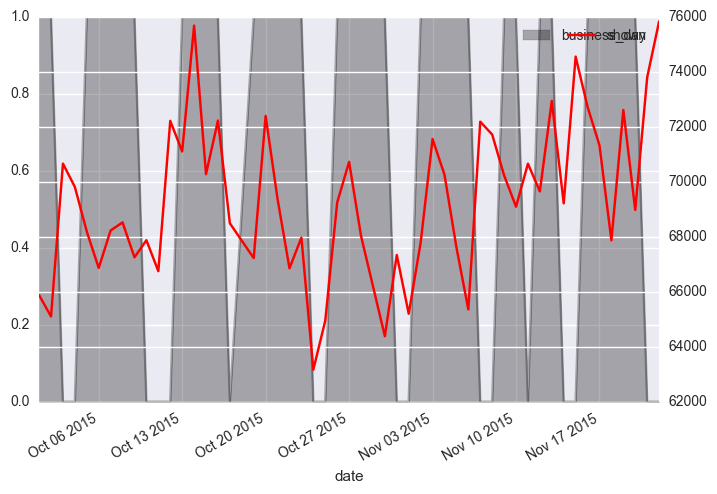

In [125]:
ax =df_prediction.ix[df_prediction['ad'] == 'ad_group_1'].plot('date', 'business_day', color = 'black', 
                                                               alpha = 0.3, kind = 'area')
ax2 = ax.twinx()
df_prediction.ix[df_prediction['ad'] == 'ad_group_1'].plot('date', 'shown', ax = ax2, color = 'red')

It looks like there is no clear correlation between the business day and the number of ads shown. Anyway, we will retain this parameter in the dataset and check for the weightage or importance in the modeling step.

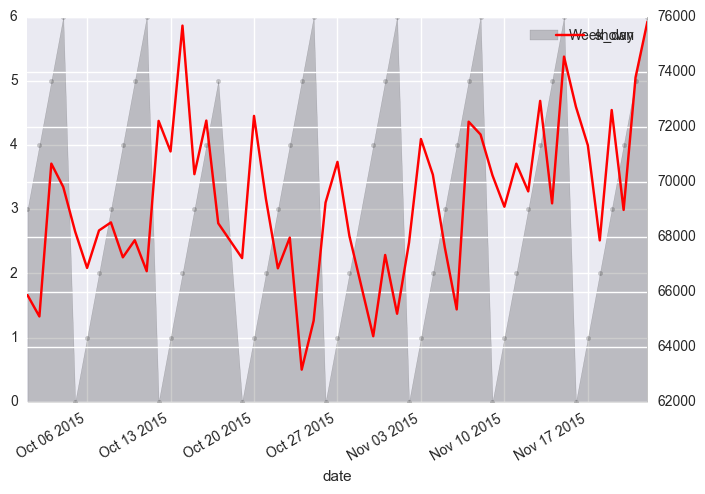

In [139]:
ax = df_prediction.ix[df_prediction['ad'] == 'ad_group_1'].plot('date', 'Week_day', color = 'black', 
                                                               alpha = 0.2, kind = 'area', style = '.')
ax2 = ax.twinx()
df_prediction.ix[df_prediction['ad'] == 'ad_group_1'].plot('date', 'shown', ax = ax2, color = 'red')

One thing that is slightly apparent from the above plot is that the shown usually drops during mid-week days compared to the beginning and the ending of a week. So this parameter might have an impact on how many ads will be shown on a particular weekday.

The 'date' parameter can  be deleted as we have extracted the required information such as business day and week day from it. 

In [140]:
df_prediction.drop('date', axis = 1, inplace = 1)

In [141]:
df_prediction.head()

,shown,clicked,converted,avg_cost_per_click,ad,business_day,Week_day,CPC_1,WS_1
0,65877,2339,43,0.90,ad_group_1,True,3,0.109313,0.583097
1,65100,2498,38,0.94,ad_group_1,True,4,0.086605,0.584413
2,70658,2313,49,0.86,ad_group_1,False,5,0.131826,0.601530
3,69809,2833,51,1.01,ad_group_1,False,6,0.095385,0.584026
4,68186,2696,41,1.00,ad_group_1,True,0,0.081385,0.584733


<b> Alright! Now its time to normalize the parameters.

In [ ]:
When to apply minmax scaler and when to apply max normalization?